# Fade Trading Analysis

Analyze fade trading results from JSON files

In [3]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 44.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 46.2 MB/s eta 0:00:00
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [4]:
def json_to_dataframe(json_file, save_csv=True):
    """Load JSON trading data and convert to DataFrame with full analysis columns"""

    def extract_excess_move(reason):
        """Extract excess move amount from reason string"""
        match = re.search(r'excess: \$([0-9.-]+)', reason)
        return float(match.group(1)) if match else 0.0

    def extract_price_move(reason):
        """Extract price move amount from reason string"""
        if 'Fade' in reason or 'Reduce' in reason:
            match = re.search(r'(Fade|Reduce) \$([0-9.-]+)', reason)
            return float(match.group(2)) if match else 0.0
        return 0.0

    def get_trade_type(reason):
        """Determine if trade is fade, reduce, or flatten"""
        if 'Fade' in reason:
            return 'Fade'
        elif 'Reduce' in reason:
            return 'Reduce'
        elif 'flatten' in reason:
            return 'Flatten'
        else:
            return 'Other'

    # Load JSON data
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract session info
    if 'backtest_info' in data:
        session_info = data['backtest_info']
        session_type = 'backtest'
    elif 'session_info' in data:
        session_info = data['session_info']
        session_type = session_info.get('session_type', 'live_trading')
    else:
        raise ValueError("Invalid file format")

    # Convert trades to DataFrame
    df = pd.DataFrame(data['trades'])

    if df.empty:
        print("No trades found!")
        return df, session_info, session_type

    # Process timestamps
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['date'] = df['timestamp'].dt.date
    df['time'] = df['timestamp'].dt.strftime('%H:%M:%S.%f').str[:-3]  # Include milliseconds
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['second'] = df['timestamp'].dt.second

    # Extract additional fields from reason
    df['excess_move'] = df['reason'].apply(extract_excess_move)
    df['price_move'] = df['reason'].apply(extract_price_move)
    df['trade_type'] = df['reason'].apply(get_trade_type)

    # Calculate running position
    df['position_after'] = 0
    position = 0
    for i, row in df.iterrows():
        if row['action'] == 'BUY':
            position += row['quantity']
        else:  # SELL
            position -= row['quantity']
        df.loc[i, 'position_after'] = position

    # Add position change
    df['position_change'] = df['quantity'] * df['action'].map({'BUY': 1, 'SELL': -1})

    # Calculate trade value
    df['trade_value'] = df['quantity'] * df['price']

    # Add session info columns
    df['session_type'] = session_type
    df['session_symbol'] = session_info.get('symbol', session_info.get('symbols', ['UNKNOWN'])[0])
    df['session_date'] = session_info.get('date', 'UNKNOWN')

    # Save to CSV if requested
    if save_csv:
        csv_file = json_file.replace('.json', '_trades.csv')
        df.to_csv(csv_file, index=False)
        print(f"💾 Saved CSV: {csv_file}")

    print(f"📊 Loaded {len(df)} trades from {session_type} session")
    print(f"   Symbol: {df['session_symbol'].iloc[0]}, Date: {df['session_date'].iloc[0]}")
    print(f"   BUY: {len(df[df['action'] == 'BUY'])}, SELL: {len(df[df['action'] == 'SELL'])}")
    print(f"   Final position: {df['position_after'].iloc[-1]} shares")

    return df, session_info, session_type

# 🔥 LOAD YOUR DATA HERE - Just change the filename! 🔥
json_file = 'results/backtests/live_TSLA_20250918_live-1600.json'
df, session_info, session_type = json_to_dataframe(json_file, save_csv=True)

print(f"\n📋 DataFrame shape: {df.shape}")
print(f"📋 Available columns: {list(df.columns)}")
df.head()

💾 Saved CSV: results/backtests/live_TSLA_20250918_live-1600_trades.csv
📊 Loaded 92 trades from live_trading session
   Symbol: TSLA, Date: 20250918
   BUY: 57, SELL: 35
   Final position: 0 shares

📋 DataFrame shape: (92, 21)
📋 Available columns: ['timestamp', 'symbol', 'action', 'quantity', 'price', 'reason', 'type', 'date', 'time', 'hour', 'minute', 'second', 'excess_move', 'price_move', 'trade_type', 'position_after', 'position_change', 'trade_value', 'session_type', 'session_symbol', 'session_date']


,timestamp,symbol,action,quantity,price,reason,type,date,time,hour,...,second,excess_move,price_move,trade_type,position_after,position_change,trade_value,session_type,session_symbol,session_date
0,2025-09-18 14:57:05.087894,TSLA,SELL,10,424.50,Fade $1.10 move (excess: $0.10),SIMULATED,2025-09-18,14:57:05.087,14,...,5,0.1,1.10,Fade,-10,-10,4245.0,live_trading,TSLA,20250918
1,2025-09-18 14:57:06.401037,TSLA,SELL,10,424.60,Fade $1.20 move (excess: $0.20),SIMULATED,2025-09-18,14:57:06.401,14,...,6,0.2,1.20,Fade,-20,-10,4246.0,live_trading,TSLA,20250918
2,2025-09-18 14:57:17.152938,TSLA,SELL,10,424.70,Fade $1.30 move (excess: $0.30),SIMULATED,2025-09-18,14:57:17.152,14,...,17,0.3,1.30,Fade,-30,-10,4247.0,live_trading,TSLA,20250918
3,2025-09-18 15:00:25.368937,TSLA,BUY,10,424.17,Fade $0.66 move (excess: $0.00),SIMULATED,2025-09-18,15:00:25.368,15,...,25,0.0,0.66,Fade,-20,10,4241.7,live_trading,TSLA,20250918
4,2025-09-18 15:00:31.052590,TSLA,BUY,10,423.88,Fade $-0.90 move (excess: $0.00),SIMULATED,2025-09-18,15:00:31.052,15,...,31,0.0,-0.90,Fade,-10,10,4238.8,live_trading,TSLA,20250918


In [6]:
df['position_change'].sum()

np.int64(0)

In [8]:
(df['position_change'] * df['price'] * -1).sum()

np.float64(145.36999999998807)

In [31]:
def _get_total_pnl(df):
    final_execution = df['position_change'].sum() * df['price'].iloc[-1]
    pre_execution = (df['position_change'] * df['price'] * -1).sum()
    #print(f"Final execution: {final_execution}")
    #print(f"Pre-execution: {pre_execution}")

    pnl = pre_execution + final_execution
    return pnl

In [32]:
i = 1

In [33]:
_get_total_pnl(df.iloc[:i+1])

np.float64(-1.0)

In [38]:
df['cumulative_pnl'] = df.apply(lambda x: _get_total_pnl(df.iloc[:x.name+1]), axis=1)

<Axes: xlabel='timestamp'>

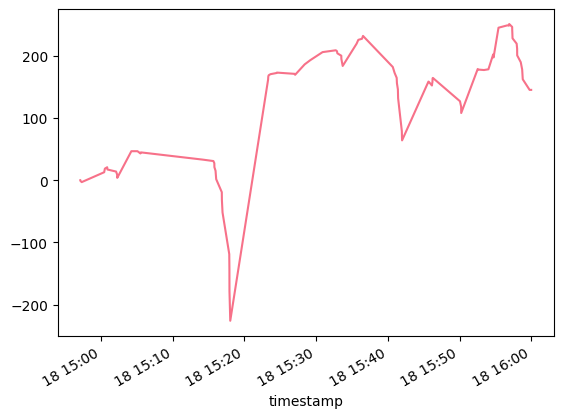

In [40]:
df.set_index("timestamp").cumulative_pnl.plot()